This notebook was made to reduce NIRSpec dithers into a spectral cube by:

1. Using the Stage 1 Detector pipleine to turn uncalibrated detector images (_uncal.fits) into rate files (_rate.fits).

2. Using Stage 2 of the Spectroscopic pipeline to turn rate files(_rate.fits) into calibrated detector images (_cal.fits) and spectral cubes (_s3d.fits)

3. Using Stage 3 of the spectroscopic pipeline to combine the stage 2 rate files from each filter/grating combination. 

Other notes/caveats:
Stage 2 cube building is redundant with Stage 3 if you are not combining dithers.

In [1]:
from astropy.io import fits
import glob, os
from subprocess import call
from astropy.io import fits
import time

import jwst
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, Spec3Pipeline

import matplotlib.pyplot as plt
import numpy as n

from spectral_cube import SpectralCube
from scipy import optimize


os.environ['CRDS_PATH'] = '/Users/zen/crds_cache/jwst_ops'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
os.environ['CRDS_CONTEXT'] = 'jwst_0977.pmap'
os.environ['CRDS_VERSION'] = '11.16.12'


# Print out what pipeline version we're using
print('JWST pipeline version',jwst.__version__)

JWST pipeline version 1.7.2


In [2]:
# Functions for fitting a 2-D guassian to images to find the PSF center in collapsed spectral cubes
def gauss2d(x, y, x0, y0, offset, sigma_x, sigma_y, A):

    x_exp = ( ( x - x0 )**2) / (2 * sigma_x ** 2)
    y_exp = ( ( y - y0 )**2) / (2 * sigma_y ** 2)
    f = A * n.exp( - x_exp - y_exp) + offset

    return f

def image_solve(constants, im):

    x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val = constants

    y_len, x_len = im.shape
    y_arr = n.arange(0, y_len)
    x_arr = n.arange(0, x_len)
    xx, yy = n.meshgrid(x_arr, y_arr)

    fit = gauss2d(xx, yy, x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val)

    min_diff = n.nansum(abs(im - fit)**2)

    return min_diff

In [3]:
det1_dir = 'stage1/' # Detector1 pipeline outputs will go here
spec2_dir = 'stage2/' # Spec2 pipeline outputs will go here
spec3_dir = 'stage3/' # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

In [4]:
uncal_file_dir = '../../../cal_data/'

uncal_files = ['jw01128009001_03106_00001_nrs2_uncal.fits',
              'jw01128009001_03106_00002_nrs2_uncal.fits',
              'jw01128009001_03106_00003_nrs2_uncal.fits',
              'jw01128009001_03106_00004_nrs2_uncal.fits']

for i, file in enumerate(uncal_files):
    uncal_files[i] = uncal_file_dir + uncal_files[i]
print(uncal_files)

print('Found ' + str(len(uncal_files)) + ' input files to process')

['../../../cal_data/jw01128009001_03106_00001_nrs2_uncal.fits', '../../../cal_data/jw01128009001_03106_00002_nrs2_uncal.fits', '../../../cal_data/jw01128009001_03106_00003_nrs2_uncal.fits', '../../../cal_data/jw01128009001_03106_00004_nrs2_uncal.fits']
Found 4 input files to process


In [5]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [6]:
for file in uncal_files:
    
    det1 = Detector1Pipeline() # Instantiate the pipeline

    #output directory
    det1.output_dir = det1_dir # Specify where the output should go

    #defining used pipeline steps
    det1.group_scale.skip = False  #scaling factor from group images
    det1.dq_init.skip = False      #data quality check
    det1.saturation.skip = False   #check for saturated pixels
    det1.ipc.skip = False          #interpixel capacitance scaling from a reference. Usually skipped in all instrument modes
    det1.superbias.skip = False    #subtract a bias frame from the data
    det1.refpix.skip = False       #correct for drifts in read outs using reference pixels or columns
    det1.linearity.skip = False    #used to correct for non-linearity in the frames
    det1.persistence.skip = True   #according to the docs it is supposed to be hardwired to skipped
    det1.dark_current.skip = False #
    det1.jump.skip = False         #
    det1.jump.maximum_cores = 'half' #distribute the computing load across half of your computer cores to speed it up
    det1.ramp_fit.skip = False     #
    det1.ramp_fit.maximum_cores = 'half' #distribute the computing load across half of your computer cores to speed it up
    det1.gain_scale.skip = False   #


    #skipped steps that are for MIRI
    det1.firstframe.skip = True    #
    det1.lastframe.skip = True     #
    det1.reset.skip = True         # The reset correction is a MIRI step that attempts to correct for the reset anomaly effect. Skipped
    det1.rscd.skip = True          # Performs an RSCD correction to MIRI data that is also caused by reset issues. Skipped



    #choose what results to save and from what steps
    #det1.dq_init.save_results = True # save the data quality flag information
    det1.save_results = True # Save the final resulting _rate.fits files

    det1.run(file)

2022-12-08 13:21:42,897 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-12-08 13:21:42,899 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-12-08 13:21:42,900 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-12-08 13:21:42,901 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-12-08 13:21:42,902 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-12-08 13:21:42,903 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-12-08 13:21:42,905 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-12-08 13:21:42,906 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-12-08 13:21:42,907 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-12-08 13:21:42,907 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-12-08 1

2022-12-08 13:21:44,288 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_mask_0033.fits'.
2022-12-08 13:21:44,289 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2022-12-08 13:21:44,289 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.
2022-12-08 13:21:44,289 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_saturation_0026.fits'.
2022-12-08 13:21:44,290 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.
2022-12-08 13:21:44,290 - stpipe.Detector1Pipeline - I

2022-12-08 13:22:23,291 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=15, nframes=1, groupgap=0
2022-12-08 13:22:23,293 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0
2022-12-08 13:22:31,131 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-12-08 13:22:31,786 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 15, 3200, 2048) from jw01128009001_03106_00001_nrs2_uncal.fits>,).
2022-12-08 13:22:31,788 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '../../../cal_data', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maxim

2022-12-08 13:22:57,657 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-12-08 13:22:57,658 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-12-08 13:22:57,659 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-12-08 13:22:57,660 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-12-08 13:22:57,661 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-12-08 13:22:57,662 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-12-08 13:22:57,663 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2022-12-08 13:22:57,664 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2022-12-08 13:22:57,665 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2022-12-08 13:22:57,666 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2022-

2022-12-08 13:22:58,043 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_saturation_0026.fits'.
2022-12-08 13:22:58,043 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.
2022-12-08 13:22:58,043 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2022-12-08 13:22:58,667 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 15, 3200, 2048) from jw01128009001_03106_00002_nrs2_uncal.fits>,).
2022-12-08 13:22:58,668 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': 

2022-12-08 13:23:41,333 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2022-12-08 13:23:41,334 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half
2022-12-08 13:23:41,434 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_gain_0020.fits
2022-12-08 13:23:41,566 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits
2022-12-08 13:23:42,114 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2022-12-08 13:23:42,203 - stpipe.Detector1Pipeline.jump - INFO - Creating 5 processes for jump detection 
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
/Users/zen/opt/miniconda3/envs/jwst_env_cur

2022-12-08 13:24:06,141 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2022-12-08 13:24:06,206 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('../../../cal_data/jw01128009001_03106_00003_nrs2_uncal.fits',).
2022-12-08 13:24:06,214 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None

2022-12-08 13:24:07,368 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2022-12-08 13:24:07,368 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2022-12-08 13:24:07,371 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2022-12-08 13:24:07,461 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 15, 3200, 2048) from jw01128009001_03106_00003_nrs2_uncal.fits>,).
2022-12-08 13:24:07,462 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '../../../cal_data'}
2022-12-08 13:24:07,482 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/zen/crds_cache/jwst_ops/references/jwst

2022-12-08 13:24:51,319 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits
2022-12-08 13:24:51,913 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2022-12-08 13:24:52,013 - stpipe.Detector1Pipeline.jump - INFO - Creating 5 processes for jump detection 
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
/Users/zen/opt/

2022-12-08 13:25:17,302 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128009001_03106_00004_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'readnoise', 'refpix', 'saturation', 'superbias']
2022-12-08 13:25:17,305 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_dark_0206.fits'.
2022-12-08 13:25:17,306 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2022-12-08 13:25:17,306 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_ipc_0012.fits'.
2022-12-08 13:25:17,307 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2022-12-08 13

2022-12-08 13:25:51,794 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2022-12-08 13:25:51,896 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 15, 3200, 2048) from jw01128009001_03106_00004_nrs2_uncal.fits>,).
2022-12-08 13:25:51,897 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '../../../cal_data', 'dark_output': None}
2022-12-08 13:25:52,076 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_dark_0206.fits
2022-12-08 13:25:56,047 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=15, nframes=1, groupgap=0
2022-1

2022-12-08 13:26:24,673 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-12-08 13:26:24,673 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0977.pmap
2022-12-08 13:26:24,869 - stpipe.Detector1Pipeline - INFO - Saved model in stage1/jw01128009001_03106_00004_nrs2_rate.fits
2022-12-08 13:26:24,869 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [9]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 285.1912 seconds


In [10]:
# Look for input uncalibrated slope files from the Detector1 pipeline
sstring = 'stage1/'+ '*_rate.fits'
rate_files = sorted(glob.glob(sstring))
print('Found ' + str(len(rate_files)) + ' input files to process')

Found 4 input files to process


In [11]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [12]:
# Setting up steps and running the Spec2 portion of the pipeline. 

spec2 = Spec2Pipeline()
spec2.output_dir = spec2_dir
spec2.assign_wcs.skip = False
spec2.bkg_subtract.skip = False
spec2.imprint_subtract.skip = False
spec2.msa_flagging.skip = False
spec2.srctype.source_type = 'POINT'
spec2.flat_field.skip = False
spec2.pathloss.skip = False
spec2.photom.skip = False
spec2.cube_build.skip = False
spec2.extract_1d.skip = True

##extra steps that only apply to other instruments modes.
spec2.extract_2d.skip = True
spec2.master_background_mos.skip = True
spec2.barshadow.skip = True
spec2.wavecorr.skip = True
spec2.straylight.skip = True
spec2.fringe.skip = True
#spec2.residual_fringe.skip = True   # is not used in 1.7.2 works in 1.8.4
spec2.wfss_contam.skip = True
spec2.resample_spec.skip = True

#choose what results to save and from what steps
spec2.save_results = True
spec2.run(rate_files)

2022-12-08 13:26:24,909 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-12-08 13:26:24,910 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-12-08 13:26:24,912 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-12-08 13:26:24,913 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-12-08 13:26:24,914 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-12-08 13:26:24,915 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-12-08 13:26:24,918 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2022-12-08 13:26:24,919 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2022-12-08 13:26:24,920 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2022-12-08 13:26:24,921 - stpipe.Spec2Pipeline.

2022-12-08 13:26:25,220 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128009001_03106_00001_nrs2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-12-08 13:26:25,225 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_area_0007.fits'.
2022-12-08 13:26:25,226 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.
2022-12-08 13:26:25,226 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.
2022-12-08 13:26:25,227 - st

2022-12-08 13:26:25,248 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-12-08 13:26:25,248 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_sflat_0095.fits'.
2022-12-08 13:26:25,248 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-12-08 13:26:25,248 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.
2022-12-08 13:26:25,249 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-12-08 13:26:25,249 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128009001_03106_00003_nrs2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 

2022-12-08 13:26:25,276 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.
2022-12-08 13:26:25,276 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_ote_0008.asdf'.
2022-12-08 13:26:25,277 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.
2022-12-08 13:26:25,277 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.
2022-12-08 13:26:25,277 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-12-08 13:26:25,277 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_sflat_00

2022-12-08 13:26:47,844 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-12-08 13:26:48,134 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw01128009001_03106_00001_nrs2_rate.fits>,).
2022-12-08 13:26:48,135 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': 'POINT'}
2022-12-08 13:26:48,144 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU
2022-12-08 13:26:48,144 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2022-12-08 13:26:48,145 - stpipe.Spec2Pipeline.srctype - WARNING - Based on user-input, setting SRCTYPE = POINT
2022-12-08 13:26:48,148 - stpipe.Spec2Pipeline.srctype - INFO - Step srctyp

2022-12-08 13:34:28,410 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 2    51  26.00  69.45832233   0.10000000  -2.55000004   2.55000004
2022-12-08 13:34:28,411 - stpipe.Spec2Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2022-12-08 13:34:28,411 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 3  1910   1.00   2.41972530   0.00039600   2.41952730   3.17588728
2022-12-08 13:34:28,411 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers grating, filter: g235h, f170lp
2022-12-08 13:34:28,411 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: stage2/jw01128009001_03106_00001_nrs2_s3d.fits
2022-12-08 13:34:32,056 - stpipe.Spec2Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: stage2/jw01128009001_03106_00001_nrs2_cal.fits
2022-12-08 13:35:52,299 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2022-12-08 13:35:52,299 - stpipe.Spec2Pipeline.cube_build - INFO - Total #

2022-12-08 13:36:02,351 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1380488 deg
2022-12-08 13:36:02,351 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3532653150000012 deg
2022-12-08 13:36:02,352 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0018865959647736948 deg
2022-12-08 13:36:02,353 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.00011620025040863247 deg
2022-12-08 13:36:02,367 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]
2022-12-08 13:36:02,461 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.000000367120778
2022-12-08 13:36:02,497 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1
2022-12-08 13:36:02,541 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-12-08 13:36:02,565 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3
2022-12-08

2022-12-08 13:44:07,790 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-12-08 13:44:07,791 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle
2022-12-08 13:44:07,791 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-12-08 13:44:07,819 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_cubepar_0003.fits
2022-12-08 13:44:07,866 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFUcube are constructed from all the data 
2022-12-08 13:44:07,866 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1
2022-12-08 13:44:07,870 - stpipe.Spec2Pipeline.cube_build - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2022-12-08 13:44:07,872 - stpipe.Spec2Pipeline.cube_build - INFO - Cube Geometry:
2022-12-08 13:44:07,873 - stpipe.Spec2Pipeline.cube_build - INFO - axi

2022-12-08 13:45:45,027 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-12-08 13:45:45,029 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-12-08 13:45:45,315 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw01128009001_03106_00003_nrs2_rate.fits>,).
2022-12-08 13:45:45,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': ''}
2022-12-08 13:45:45,336 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json
2022-12-08 13:45:45,337 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-12-08 

2022-12-08 13:53:03,647 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1
2022-12-08 13:54:06,801 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-12-08 13:54:07,704 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from stage2/jw01128009001_03106_00003_nrs2_cal.fits>,).
2022-12-08 13:54:07,705 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflaggin

2022-12-08 13:55:51,404 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'bkg_subtract', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2022-12-08 13:55:51,405 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2022-12-08 13:55:51,407 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-12-08 13:55:51,770 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw01128009001_03106_00004_nrs2_rate.fits>, []).
2022-12-08 13:55:51,771 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-12-08 14:03:07,259 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-12-08 14:03:07,292 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_photom_0016.fits
2022-12-08 14:03:07,292 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /Users/zen/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_area_0007.fits
2022-12-08 14:03:09,944 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC
2022-12-08 14:03:09,945 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2
2022-12-08 14:03:09,945 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU
2022-12-08 14:

[<IFUImageModel(2048, 2048) from jw01128009001_03106_00001_nrs2_cal.fits>,
 <IFUImageModel(2048, 2048) from jw01128009001_03106_00002_nrs2_cal.fits>,
 <IFUImageModel(2048, 2048) from jw01128009001_03106_00003_nrs2_cal.fits>,
 <IFUImageModel(2048, 2048) from jw01128009001_03106_00004_nrs2_cal.fits>]

In [13]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2362.9383 seconds


In [14]:
### Calling in the calibrated detector images produced by running the stage 2 pipeline on the modified NRS fits files
cal_files = glob.glob('stage2/*cal.fits')
print(cal_files)

['stage2/jw01128009001_03106_00004_nrs2_cal.fits', 'stage2/jw01128009001_03106_00003_nrs2_cal.fits', 'stage2/jw01128009001_03106_00002_nrs2_cal.fits', 'stage2/jw01128009001_03106_00001_nrs2_cal.fits']


In [15]:
## create association file for dithered data. Make a json file for the dither set.
call(["asn_from_list", "-o","l3_asn.json"] + cal_files + ["--product-name", "dither"])

0

In [16]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [17]:
# This initial setup is just to make sure that we get the latest parameter reference files
# pulled in for our files.  This is a temporary workaround to get around an issue with
# how this pipeline calling method works.
#
# Setting up steps and running the Spec3 portion of the pipeline. Outlier detector is skipped
# because it tends to cut high value pixels even if it is a part of the target.

json_file = 'l3_asn.json'
crds_config = Spec3Pipeline.get_config_from_reference(json_file)# The exact asn file used doesn't matter
spec3 = Spec3Pipeline.from_config_section(crds_config)
spec3.output_dir = spec3_dir
spec3.assign_mtwcs.skip = True               #skipped because VHS 1256b is not a moving target
spec3.master_background.skip = False
spec3.outlier_detection.skip = True
spec3.cube_build.skip = False
spec3.cube_build.coord_system = 'skyalign'   
spec3.cube_build.output_type = 'band'        # is the default mode for calspec3 and creates IFU cubes containing only one band (channel/sub-channel for MIRI or grating/filter combination for NIRSpec).

#used on MRS or other modes
spec3.mrs_imatch.skip = True
spec3.resample_spec.skip = False
spec3.combine_1d.skip = True

#save results
spec3.save_results = True
spec3(json_file)

2022-12-08 14:05:52,998 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2022-12-08 14:05:52,999 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-12-08 14:05:53,000 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2022-12-08 14:05:53,001 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2022-12-08 14:05:53,002 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-12-08 14:05:53,004 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2022-12-08 14:05:53,005 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2022-12-08 14:05:53,007 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2022-12-08 14:05:53,008 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2022-12-08 14:05:53,009 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

2022-12-08 14:06:11,484 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': False}
2022-12-08 14:06:11,484 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-12-08 14:06:11,485 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: drizzle
2022-12-08 14:06:11,485 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-12-08 14:06:11,539 - stpipe.Spec3Pi

In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 393.7680 seconds


<IPython.core.display.Javascript object>


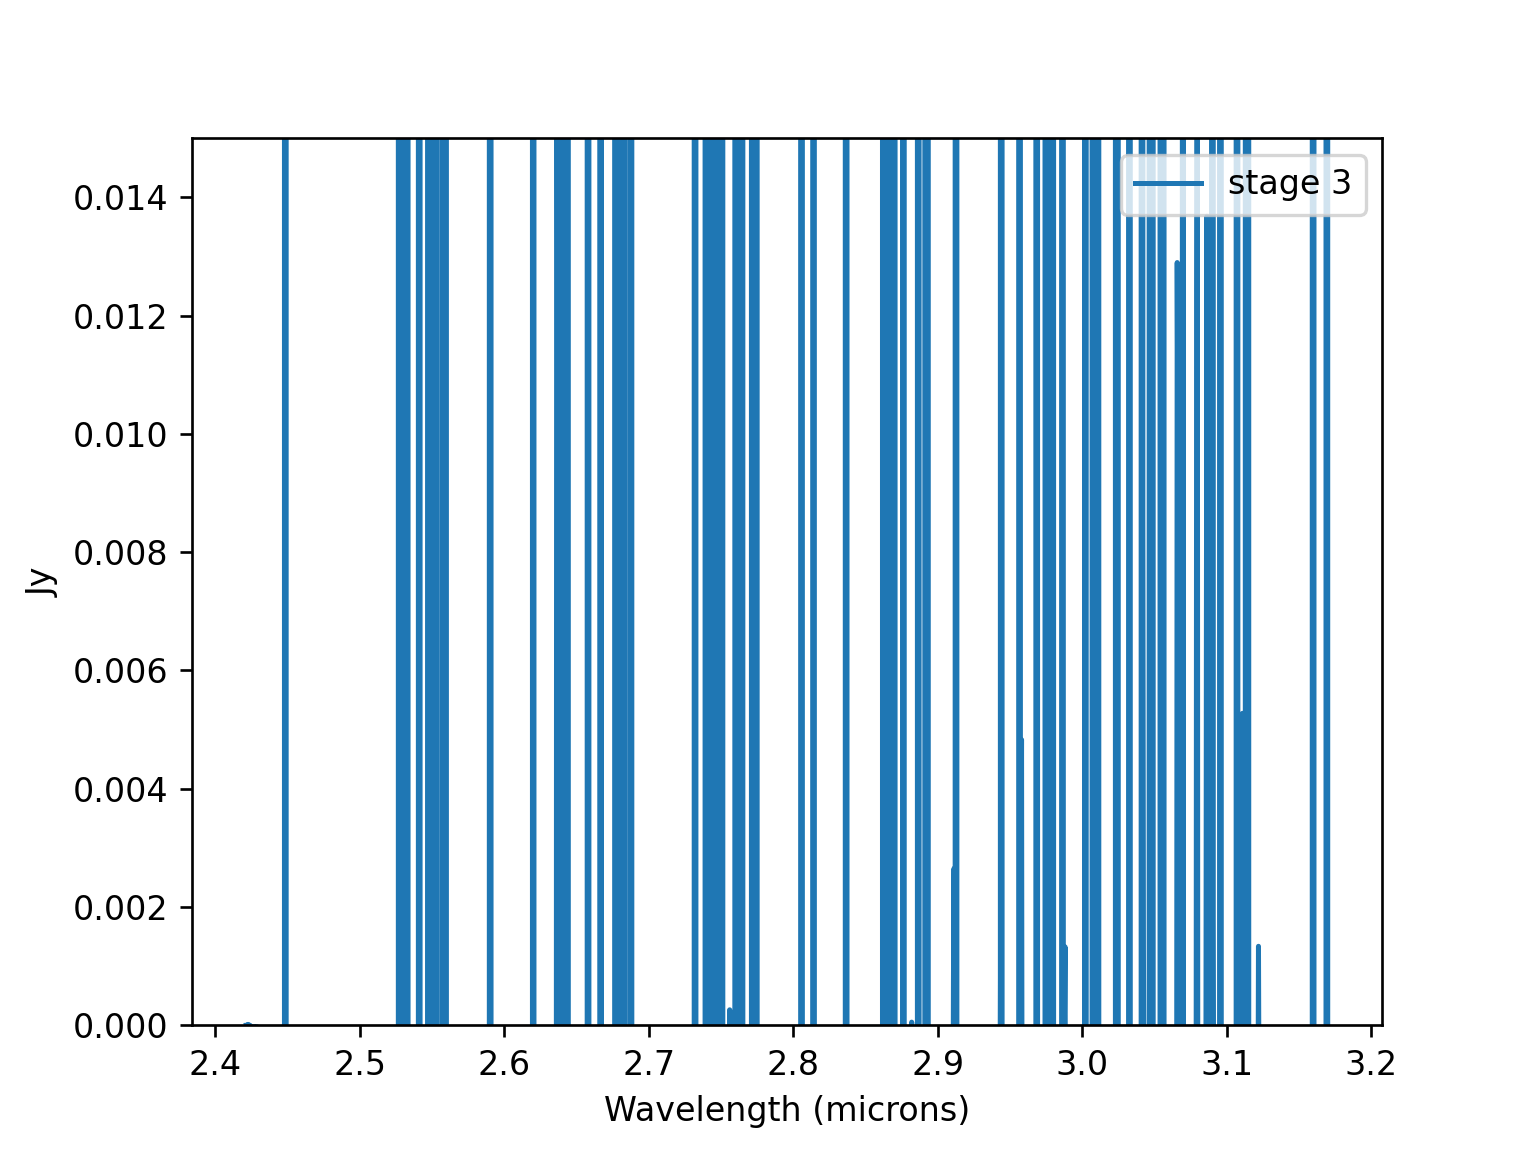

In [24]:
# check the extracted spectrum from the JWST pipeline
data = fits.getdata('stage3/dither_g235h-f170lp_x1d.fits')
wavelength = data['wavelength']
flux  = data['flux']
flux_error = data['flux_error']

%matplotlib notebook
plt.plot(wavelength, flux, label = 'stage 3')
plt.ylim([0,.015])
plt.ylabel('Jy')
plt.xlabel('Wavelength (microns)')
plt.legend()

In [25]:
cube_data = fits.getdata('stage3/dither_g235h-f170lp_s3d.fits')
cube=SpectralCube.read('stage3/dither_g235h-f170lp_s3d.fits',hdu=1)

wavelength=cube.spectral_axis
wavelength=n.array(wavelength)

cube_collapse = n.nanmedian(cube_data, axis = 0)
cube_collapse /= n.nanmax(cube_collapse) #the image is normalized so the 2-D Gaussian fit is easier.

<IPython.core.display.Javascript object>


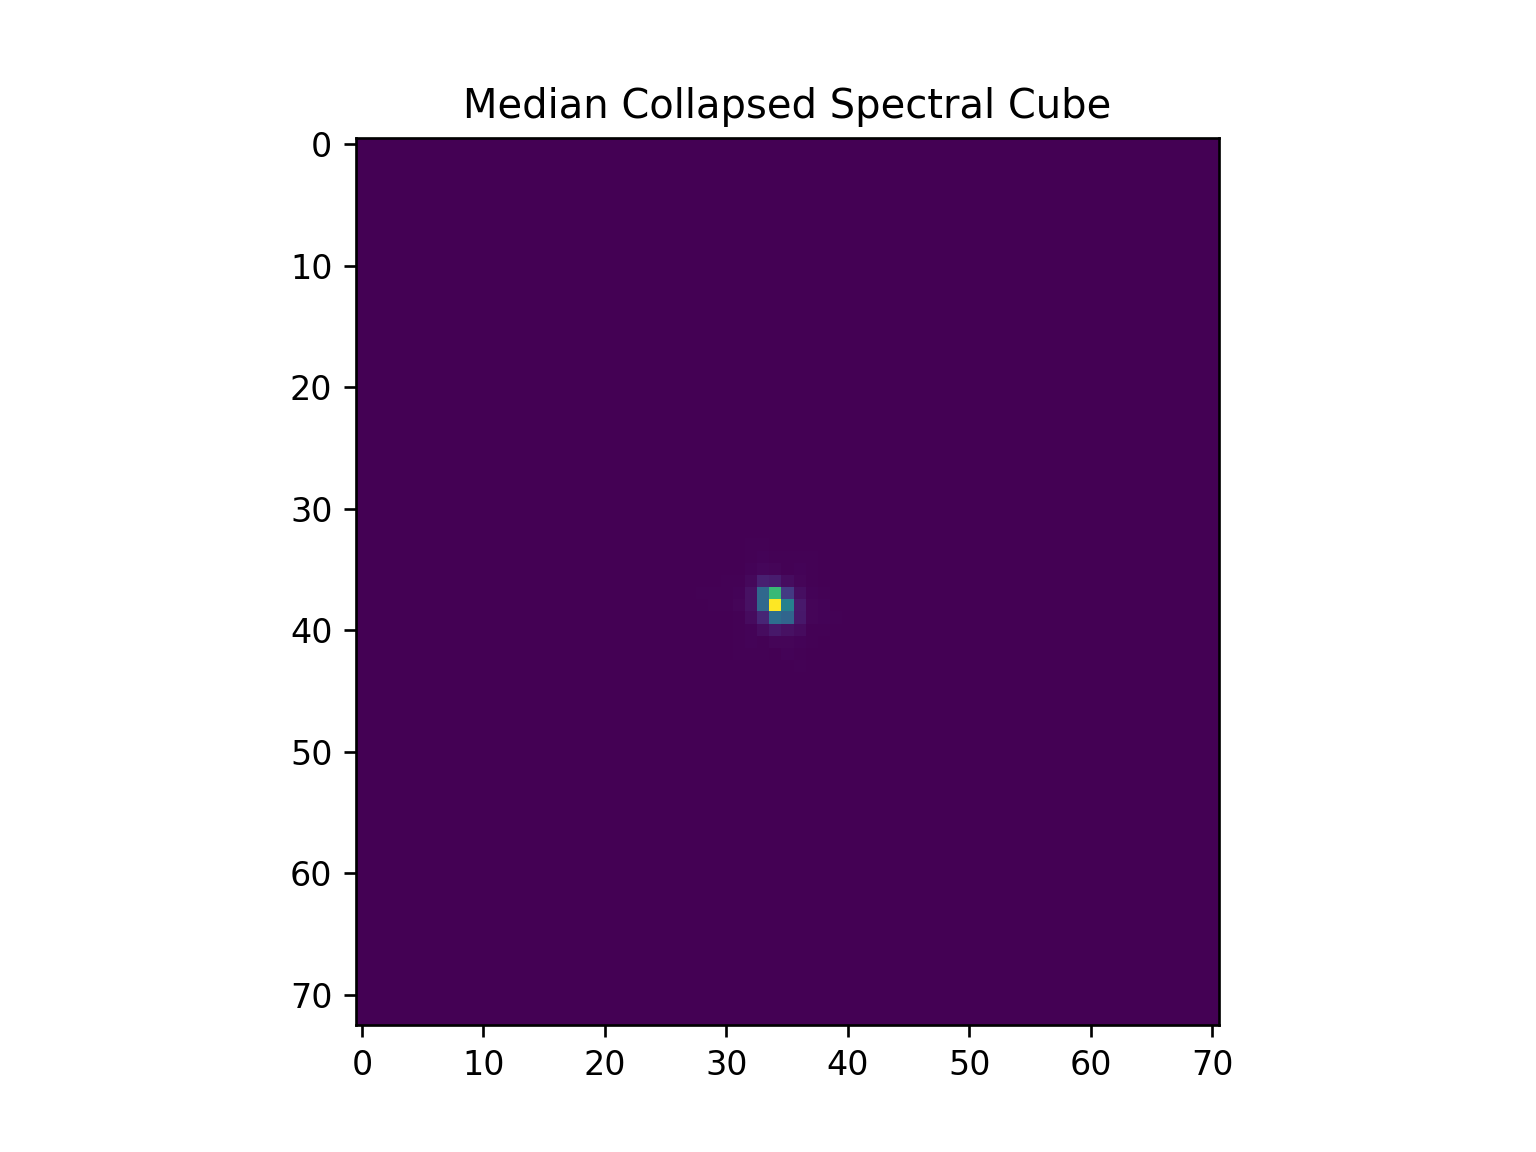

In [26]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.title('Median Collapsed Spectral Cube')
plt.imshow((cube_collapse))
plt.show()

In [27]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([34, 38, n.nanmin(image), 1.2, 1.2, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x


x0_fit = n.round(x0_fit, decimals = 0) #rounding because jwst pipeline does not take float values
y0_fit = n.round(y0_fit, decimals = 0) #rounding because jwst pipeline does not take float values


print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

centroids (x, y)
34.0 38.0
sigmax, sigma y
1.000277954967774 1.004787658025417


In [28]:
#re-running the jwst pipeline extraction step to ensure the extraction radius is centered.
spec3.extract_1d.center_xy = (int(x0_fit), int(y0_fit))
spec3.extract_1d('stage3/dither_g235h-f170lp_s3d.fits')

2022-12-09 11:29:51,108 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args ('stage3/dither_g235h-f170lp_s3d.fits',).
2022-12-09 11:29:51,110 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': [34, 38], 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-12-09 11:29:51,380 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/zen/crds_cache/jwst_ops/references/jwst/n

<MultiSpecModel from dither_g235h-f170lp_x1d.fits>

<IPython.core.display.Javascript object>


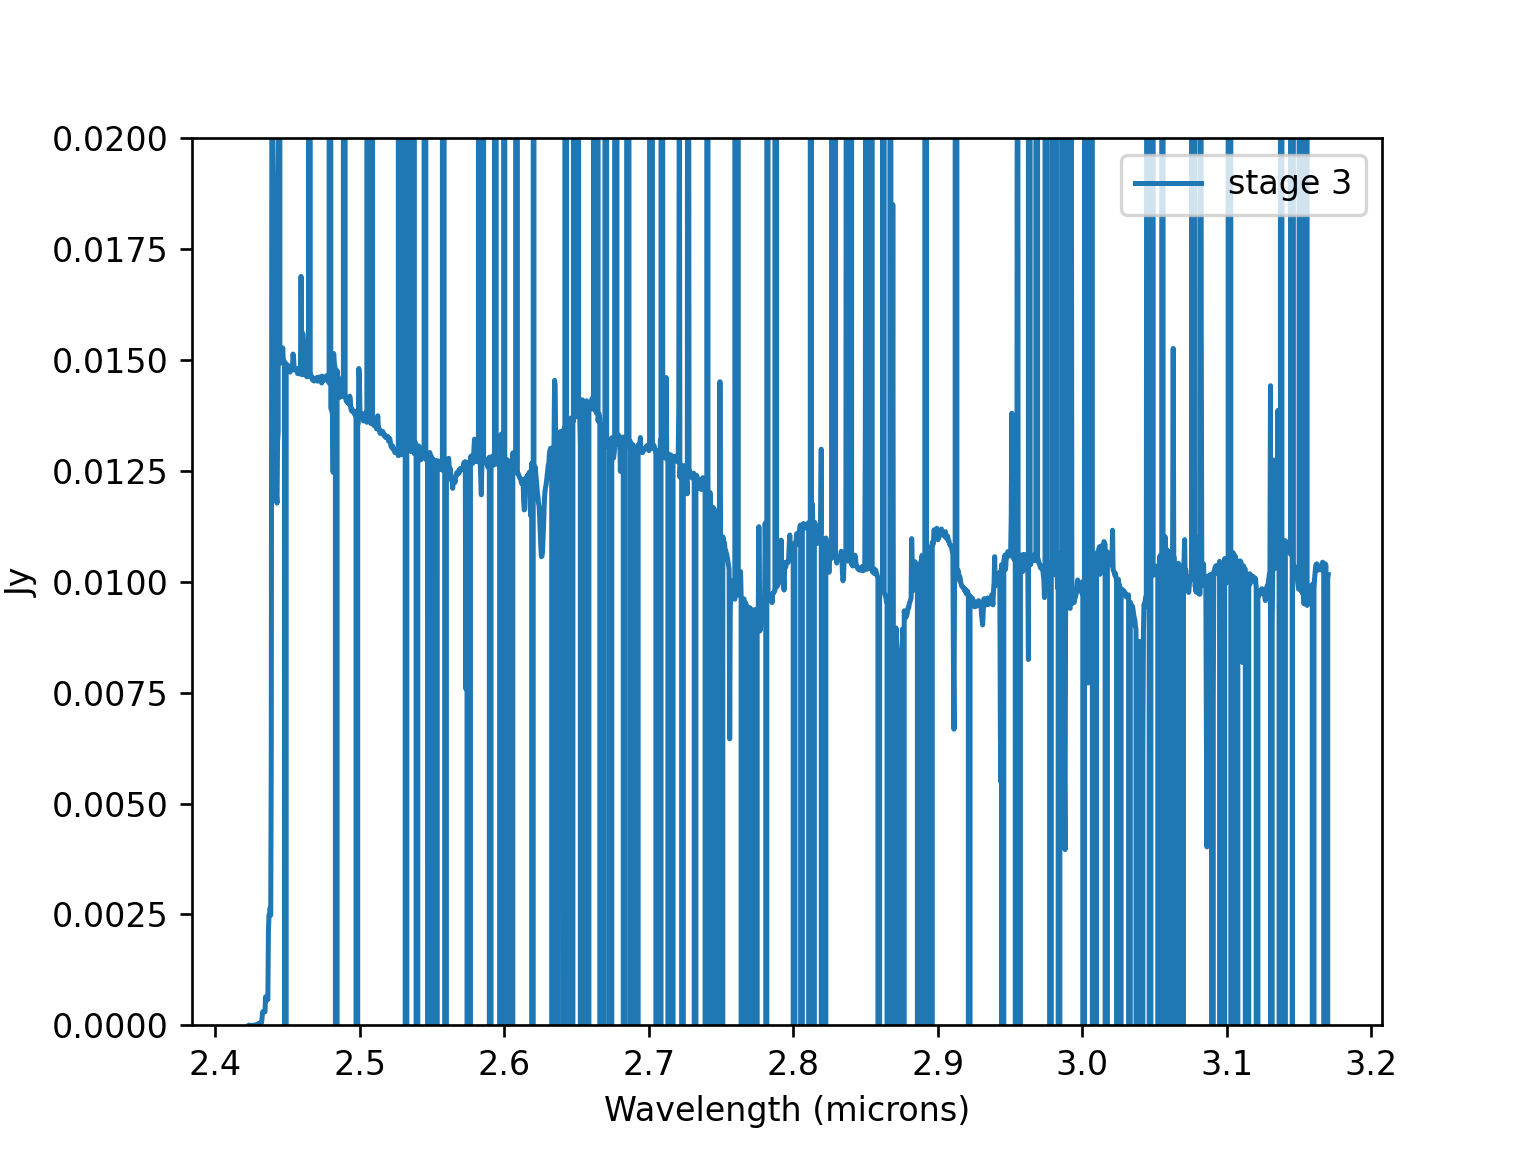

In [30]:
# check the extracted spectrum from the JWST pipeline
data = fits.getdata('stage3/dither_g235h-f170lp_x1d.fits')
wavelength = data['wavelength']
flux  = data['flux']
flux_error = data['flux_error']

%matplotlib notebook
plt.plot(wavelength, flux, label = 'stage 3')
plt.ylim([0,.020])
plt.ylabel('Jy')
plt.xlabel('Wavelength (microns)')
plt.legend()

In [26]:
#save text
#data_out = n.vstack((wavelength,  flux , flux_error))
#data_out = n.transpose(data_out)
#
#spectra_dir = '../spectra/' # Detector1 pipeline outputs will go here
#if not os.path.exists(spectra_dir):
#    os.makedirs(spectra_dir)
#
#header = 'wavelength (microns) flux(Jy), flux error(Jy)'
#n.savetxt('../spectra/detector2_f170lp_g235h.txt', data_out, header = header)